# ============================================================

# Product Recommendations Using Apache Spark + Magellan

What is Magellan ?

- Magellan is a flexible, AI-powered Analytics platform that combines open source ML with advanced analytics, enterprise-grade BI, and capabilities to acquire, merge, manage and analyze Big Data and Big Content stored in your Enterprise Information Management (EIM) systems. Magellan enables machine-assisted decision making, automation, and business optimization.

What is Spark Machine Learning ?

- Apache Spark’s machine learning library makes practical machine learning scalable and easy. The library consists of common machine learning algorithms and utilities, including classification, regression, clustering, collaborative filtering, dimensionality reduction, lower-level optimization primitives, and higher-level pipeline APIs.

What is this Notebook about?

- In this magellan notebook, you will use Apache Spark and the Spark machine learning library to build a Product Recommendation System for Innovate Bank

How Does a Recommendation Engine Work?
- There are different methods for building a recommender system, such as, user-based, content-based, or collaborative filtering. Collaborative filtering calculates recommendations based on similarities between users and products. For example, collaborative filtering assumes that customers that purchase similar financial products will also have similar opinions on financial products that they haven't purchased. The alternating least squares (ALS) algorithm provides collaborative filtering between users and products to find products that the customers might like, based on their previous purchase history.

Notebook Requirements: 
- customer_accounts (Historical Data on Products Purchased By Customers)
- customer_offers (Sample Data To Score - list of products customers do not currently have)
- Magellan - Pyspark Kernel
- Magellan Version 16.6

# ============================================================

# In this notebook, you will learn how to:
1. Import Packages and load data stored in Magellan Data Lake (HDFS)
2. Conduct Data Exploration Using Pandas and matplotlib
3. Build a recommendation model and tune algorithm parameters
4. Initialize the final model
5.  Save & Deploy a machine learning pipeline - so that operational users can access the model and make predictions

# 1. Import Packages and load data stored in Magellan Data Lake (HDFS)


In [1]:
# upload packages
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

# machine learning packages
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALSModel, ALS
from pyspark.ml.feature import SQLTransformer
from pyspark.sql.types import IntegerType, StructType, StructField


In [2]:
# import data from hdfs / spark gateway
Customer_Accounts = spark.sql("select customer_urn, productid,products, rating from product_recommender.customer_accounts")


# 2. Conduct Data Exploration Using Pandas and matplotlib


- Show top 5 records
- Change data type to fit algorithm requirements
- Remove missing values & count number of records
- Visualize number of accounts within the investment category (by Product)

In [3]:
# list of top 5 customer records 
Customer_Accounts.show(5)

+------------+---------+----------------+------+
|customer_urn|productid|        products|rating|
+------------+---------+----------------+------+
|  1000001826|        9| Investment ISAs|     1|
|  1000001826|       23|Traditional IRAs|     1|
|  1000007658|       16|        Property|     1|
|  1000007658|       23|Traditional IRAs|     1|
|  1000009084|       11|            Loan|     1|
+------------+---------+----------------+------+
only showing top 5 rows



In [4]:
# change datatype for customer urn (integer), productid (integer) and rating (float) - this is the required input for ALS
Customer_Accounts = Customer_Accounts.withColumn('customer_urn', col('customer_urn').cast(IntegerType()))
Customer_Accounts = Customer_Accounts.withColumn('productid', col('productid').cast(IntegerType()))
Customer_Accounts = Customer_Accounts.withColumn('rating', col('rating').cast(FloatType()))

In [8]:
# Remove rows that have missing values or no customer urns
Customer_Accounts = Customer_Accounts.na.drop(subset=["customer_urn"])
print "There are ", format(Customer_Accounts.count(),',d'), " customer records in the Accounts Table"

There are  2,095,562  customer records in the Accounts Table


In [17]:
#convert to pandas dataframe for plotting
all_accounts = Customer_Accounts.toPandas()

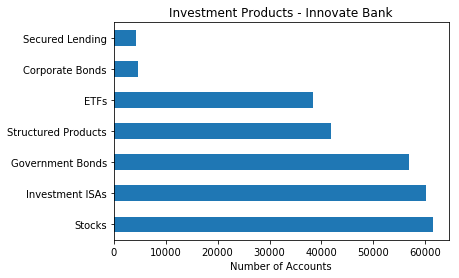

In [18]:
#select all investment products
investment_accounts = all_accounts.loc[(all_accounts['products']  == 'Investment ISAs') | 
                                       (all_accounts['products']  == 'Mutual Funds') | 
                                       (all_accounts['products']  == 'Structured Products')|
                                       (all_accounts['products']  == 'Stocks')|
                                       (all_accounts['products']  == 'Government Bonds')|
                                       (all_accounts['products']  == 'Secured Lending')|
                                       (all_accounts['products']  == 'Corporate Bonds')|
                                       (all_accounts['products']  == 'ETFs'),]

#barplot for # of investment products
investment_accounts['products'].value_counts().plot(kind = 'barh')
plt.xlabel('Number of Accounts')
plt.title('Investment Products - Innovate Bank')
plt.show()

Notes
-  Stocks and investments ISAs are the most popular Investment type products

# 3. Build a recommendation model and tune algorithm parameters


ALS algorithm has training parameters such as rank for matrix factors and regularization constants. To determine a good combination of the training parameters, we will evaluate rmse for each set of parameters. We will train the model on 80% of the data, and then use the trained algorithm to make predictions on the remaining test set (20%). Next, we will compare the predicted rating with the actual rating in the testset and calculate RMSE. RMSE represents the sample standard deviation of the differences between the predicted values with the actual values. 

- Split data into train and test model (80/20 split)


In [19]:
(train,test) = Customer_Accounts.randomSplit([0.8, 0.2], seed = 123)

- Now we will evaluate the accuracy of the model based on changes to the rank parameter 
- Rank is equal to number of latent factors to create for the model

In [20]:
# Let's try out a few values for the rank parameter
ranks = [3,6,9,12]

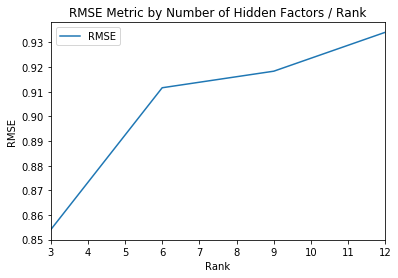

In [21]:
# setup a data frame to track evaluation results
rank_results = pd.DataFrame(columns=['Rank','RMSE'])
minimum_error = float('inf') 

for i in ranks:

        # Create an als model with the given set of specific paramters 
        als_validation = ALS(maxIter=5 ,rank =i,implicitPrefs=True, userCol="customer_urn", itemCol="productid", ratingCol="rating", nonnegative=True)
        model = als_validation.fit(train)
        
        #predict ratings for the test set using above trained model
        predictions = model.transform(test)
        
        # drop missing values from prediciton - else rmse will be Nan 
        predicted_ratings_df = predictions.filter(predictions.prediction != float('nan'))
        
        #evaluate predictions by calculating rmse
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                        predictionCol="prediction")
        # store rmse
        rmse = evaluator.evaluate(predicted_ratings_df)
        
        # append rank results to a dataframe
        rank_results = rank_results.append({'Rank':i, 'RMSE':rmse}, ignore_index=True)

        # store model results for this iteration and compare to previous iteration results
        if rmse < minimum_error:
            minimum_error = rmse

            # store value for the best rank
            best_rank = i
        
        
# plot the value vs accuracy results for rank by RMSE
rank_results.plot(x='Rank',y='RMSE')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.title('RMSE Metric by Number of Hidden Factors / Rank')
plt.show()


# 4. Initialize the final recommender model

- Algorithm: Alternating Least Squares
- Type: Implicit Feedback (This parameter is used since the ratings in this data are implicit (customer purchased a product = 1, and not explicit. An example of explicit ratings will be if the customer rated a product on a scale of 1 - 5)
- Add a sql transformer to convert predictions to 2 decimal places

In [22]:
# Set the parameters for the final als model
als = ALS(maxIter= 5 ,rank = best_rank, implicitPrefs=True, userCol="customer_urn", itemCol="productid", ratingCol="rating", nonnegative = True)

# train als model with above paramters on accounts dataset
cf_model = als.fit(train)

In [23]:
# format predictions to 2 decimal places
sql_round = SQLTransformer(statement="SELECT customer_urn, productid, products, round(prediction,2) as prediction FROM __THIS__")

In [24]:
# setup the pipeline
pipeline = Pipeline(stages=[cf_model,sql_round])

In [25]:
# fit pipeline on the customer accounts data
final_pipeline = pipeline.fit(train)

# 5.  Save & deploy the machine learning pipeline to empower users
- Save the model pipeline to magellan datalake
- Click on Publish to Magellan Data Discovery and complete form as below

In [26]:
#save ML pipeline
final_pipeline.write().overwrite().save("hdfs://10.18.50.224/OpenText/models/Financial_Product_Recommender")

1. User: Type your Data Discovery username: username@magellan
- Password: Type your Data Discovery password
- Repository: Select Spark Gateway
- Name: type "Product Recommender Model Using Spark ML"
- Description: "Leverage spark machine learning to predict products that the customer might like, based on their previous purchase history"
- The model path uses the format hdfs://ambari/OpenText/models/, without the final slash. Replace the name ambari with the hostname of your server running the Ambari dashboard. For example in this scenario, we are using: hdfs://10.18.50.224/OpenText/models/Financial_Product_Recommender
- Category: Select Recommender
- Label: Ratings (Target or Outcome column)
- Degradation Warning - Set as needed, for now we can keep it at 10%
- Schema Definition: In Dataframe variable, type train, and choose Obtain. Magellan will automaticlly detect relevant columns / fields used to build the ML pipeline. Make sure to remove column "rating" (since that is the outcome of the model).
- Set the security to Share with work group (as needed), and choose Publish
- Close the window if it says your model was published.


- Your machine learning pipeline is now available for users in Magellan Data Discovery when they are connected to the Spark repository
- Note: In order to score new data with the above created ML Model in Data Discovery, it requires customer_urn and productid fields as integer inputs (sample data provided = "customer_offers")

# Done!

# ===========================================================

# Author

Arjun Arora is a Data Scientist at Opentext. He specializes in technology evangelism, data science training, demos, and proof of concepts, that leverage Opentext Magellan and Big Data technologies, such as, Apache Hadoop and Apache Spark.

For questions, please reach out to arjuna@opentext.com

Date: 1/28/2020